# Class 26:  Bayesian Networks
## Infer a Bayesian network from a matrix of discretized phospho-flow cytometry data.
### Based on supplementary data from the 2005 article by Karen Sachs et al. (Science v308, 2005). 

In this class exercise, we will use the fundamental theorem for the likelihood of a Bayesian network structure for categorical variables, in order to score the posterior probability of the network shown in the Sachs et al. article (Figure 3A) vs. the phospho-flow cytometry data that the same authors provided in their supplementary data. The phospho-flow cytometry data have been already discretized for you (see "class26_bayesnet_dataprep_R.ipynb").  We will need to implement a single-vertex log-likelihood function using Theorem 1 from the article by Cooper & Herskovits in *Machine Learning* (volume 9, pages 309-347, 1992).

Load the tab-delimited data file of discretized phosphoprotein expression data (12 columns; first 11 columns are the expression levels -- "low", "medium", "high"; last column is the experiment identifier for the row; there are nine experiments). Print out the first six lines of the data frame, so you can see what it looks like.

In [1]:
g_discret_data <- read.table("shared/sachs_data_discretized.txt",
                          sep="\t",
                          header=TRUE,
                          quote="",
                          comment.char="",
                          stringsAsFactors=TRUE)
head(g_discret_data)

praf,pmek,plcg,PIP2,PIP3,p44.42,pakts473,PKA,PKC,P38,pjnk,expt
low,low,low,low,high,low,low,medium,medium,high,high,1_cd3cd28
low,low,medium,low,low,medium,medium,medium,low,low,high,1_cd3cd28
medium,high,medium,low,medium,medium,medium,medium,medium,medium,medium,1_cd3cd28
medium,high,medium,low,low,low,low,medium,medium,medium,medium,1_cd3cd28
low,medium,low,low,medium,medium,medium,low,low,medium,high,1_cd3cd28
low,low,medium,low,low,medium,medium,medium,medium,high,high,1_cd3cd28


Define a log probability function for the vertex degree distribution (the network structure prior):

In [2]:
log_prob_network_prior <- function(network) {
    vert_degrees <- apply(network, 1, sum) + apply(network, 2, sum)
    sum(log((1+vert_degrees)^(-2)))
}

Define a log likelihood function for a single vertex, based on Theorem 1 in the 1992 article in *Machine Learning* by Cooper & Herskovits. Note:  we are using igraph's adjacency matrix format which is the transpose of Newman's adjacency matrix definition!

In [46]:
log_likelihood_network_vertex <- function(network, vertex, discret_data) {
    parents_vertex <- which(network[,vertex]==1)
    df1 <- as.data.frame(table(discret_data[,c(vertex, parents_vertex)]))
    df1$Freq <- lfactorial(df1$Freq)
    names(df1)[1] <- "vertex"
    names(df1)[ncol(df1)] <- "countfactorial"
    if (length(parents_vertex) > 0) {
        nijk <- aggregate(countfactorial~.,
                          data=df1[, ! ("vertex" == names(df1))],
                          sum)
        nij <- as.data.frame(table(discret_data[,parents_vertex]))
        nij$Freq <- log(2) - lfactorial(nij$Freq + 2)
        names(nij)[ncol(nij)] <- "countfactorial"
        llh_res <- sum(nijk$countfactorial + nij$countfactorial)
    }
    else { # in this case just return 
        llh_res <- log(2) - lfactorial(nrow(discret_data) + 2) + sum(df1$countfactorial)
    }
    llh_res
}

In [47]:
log_likelihood_network_vertex(real_network_adj, 1, g_discret_data)

[1] -6908.596

Define a log-posterior-probability function for the whole graph, using the per-vertex likelihood and the network structure prior:

In [18]:
log_posterior_prob_network <- function(network, discret_data) {
    Nvert <- ncol(network)
    sum(sapply(1:Nvert, 
              function(vertex) {
                  log_likelihood_network_vertex(network, vertex, discret_data)
              })) + log_prob_network_prior(network)
}

Define an adjacency matrix for the "real" network shown in Fig. 3A of the Sachs et al. article (not including the "missed" edges which are the dotted arcs).

In [19]:
real_network_adj <- matrix(rep(0, 11^2), nrow=11)
rownames(real_network_adj) <- names(g_discret_data)[1:11]
colnames(real_network_adj) <- names(g_discret_data)[1:11]
real_network_adj["PKC","PKA"] <- 1
real_network_adj["PKC","praf"] <- 1
real_network_adj["PKC","pjnk"] <- 1
real_network_adj["PKC","P38"] <- 1
real_network_adj["PKA","pjnk"] <- 1
real_network_adj["PKA","P38"] <- 1
real_network_adj["PKA","praf"] <- 1
real_network_adj["PKA","pmek"] <- 1
real_network_adj["PKA","p44.42"] <- 1  # p44.42 = ERK
real_network_adj["PKA","pakts473"] <- 1
real_network_adj["p44.42","pakts473"] <- 1
real_network_adj["PKC","pmek"] <- 1
real_network_adj["praf","pmek"] <- 1
real_network_adj["pmek","p44.42"] <- 1
real_network_adj["plcg","PIP2"] <- 1
real_network_adj["plcg","PIP3"] <- 1
real_network_adj["PIP3","PIP2"] <- 1
head(real_network_adj)

,praf,pmek,plcg,PIP2,PIP3,p44.42,pakts473,PKA,PKC,P38,pjnk
praf,0,1,0,0,0,0,0,0,0,0,0
pmek,0,0,0,0,0,1,0,0,0,0,0
plcg,0,0,0,1,1,0,0,0,0,0,0
PIP2,0,0,0,0,0,0,0,0,0,0,0
PIP3,0,0,0,1,0,0,0,0,0,0,0
p44.42,0,0,0,0,0,0,1,0,0,0,0


Make an igraph network out of the adjacency matrix that you just created, and print the network summary and plot the network.

IGRAPH DN-- 11 17 -- 
+ attr: name (v/c)


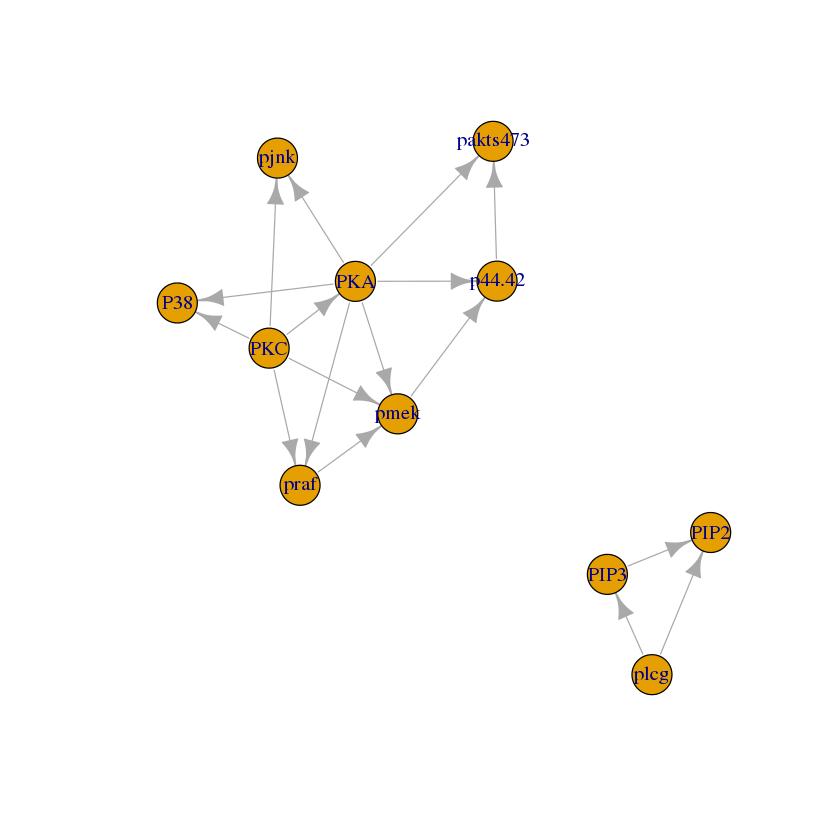

In [20]:
library(igraph)
real_network_igraph <- graph_from_adjacency_matrix(real_network_adj)
summary(real_network_igraph)
plot(real_network_igraph)

Compute the log posterior probability of the "real" network from Fig. 3A; don't forget to take the transpose (we are using Newman's convention for the adjacency matrix).

Compute the log posterior probability of the real network from Sachs *et al.* Figure 3A.

In [48]:
lpp_real_network <- log_posterior_prob_network(real_network_adj, g_discret_data)
print(lpp_real_network)

[1] -84131.03


Generate 10000 random rewirings of the network -- eliminating any rewired digraphs that contain cycles -- and for each randomly rewired DAG, histogram the log ratio of the "real" network's posterior probability to the posterior probabilities of each of the random networks. Does it appear that the published network is pretty close to the maximum *a posteriori* (MAP) estimate?   Use `library(igraph)`, `replicate`, `is_dag`, `rewire(... with=each_edge(prob=1))`, and `hist`.

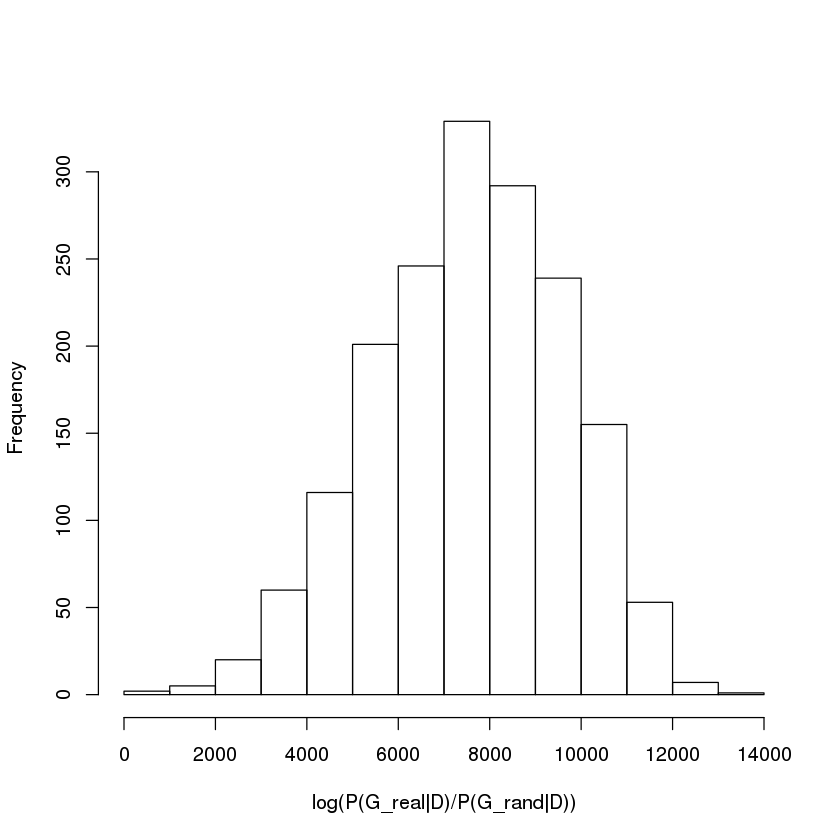

In [50]:
library(igraph)
real_network_igraph <- graph_from_adjacency_matrix(real_network_adj)
hist(na.omit(replicate(10000, 
          {
           rand_network_igraph <- rewire(real_network_igraph, 
                                  with=each_edge(prob=1))
           if (is_dag(rand_network_igraph)) {
               rand_network <- as.matrix(as_adj(rand_network_igraph))
               ret_delta_lpp <- lpp_real_network - 
                                log_posterior_prob_network(rand_network,
                                                           g_discret_data)
           } else {
               ret_delta_lpp <- NA
           }
           ret_delta_lpp
          })), xlab="log(P(G_real|D)/P(G_rand|D))", main="")